1975年から2019年までの日経225の時系列データをマルコフ・スイッチングモデルで分析する．
本稿は以下の5章からなる．
1. データの読み込み
2. モデルの説明
3. EM法による推定
4. MCMC法による推定
5. ARモデルとの組み合わせ
6. 正規性の検定

## 1. データの読み込み

日次の価格データnikkei225.csvを読み込み，月次のリターンデータに変換する．

In [13]:
%matplotlib inline

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
daily_data = pd.read_csv('nikkei225.csv')
daily_data['date'] = pd.to_datetime(daily_data['date'], format='%Y-%m-%d')
daily_data = daily_data.set_index('date')
daily_data.head()

,value
date,
1949-05-16,176.21
1949-05-17,174.80
1949-05-18,172.53
1949-05-19,171.34
1949-05-20,169.20


日次の価格のデータを1975年から2019年までの月次のリターンのデータに変換する．

In [16]:
monthy_data = daily_data.resample(rule="M").last()
monthly_return_data = monthy_data.pct_change()
monthly_return_data = monthly_return_data[308:]

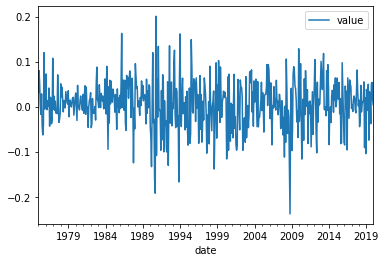

In [17]:
monthly_return_data.plot()

## 2. モデル

### 2.1 単純なレジーム・スイッチング・モデル
レジームの総数を$J$とする．$t$期の第$i$レジームのリターン$r^{(i)}(t)$とするとき，そのモデルを，
$$r^{(i)}(t)=\mu^{(i)}+\epsilon^{(i)}$$
とする．ここで，$\epsilon^{(i)}$は平均$0$，分散$(\sigma^2)^{(i)}$に従う正規分布である．

### 2.2 AR項を含むレジーム・スイッチング・モデル
さらに，このモデルにARモデルを組み合わせたモデルを
$$r^{(S_{t})}(t)=\mu^{(S_{t})} + \phi(r^{(S_{t-1})}(t-1) - \mu^{(S_{t-1})}) +\epsilon^{(S_{t})}$$
とする．ここで，$S_{t}$は第$t$期のレジームである．

### 2.3 マルコフ・スイッチング・モデル
レジームの推移確率にマルコフ性を仮定する．詳細は省略する．

## 3. EM法による推定

ライブラリstatsmodelsに含まれるマルコフ・スイッチング・モデルをEM法で推定する関数を用いて，上で紹介した単純なレジーム・スイッチング・モデルを推定する．

In [18]:
import statsmodels.api as sm

### 3.1 レジーム間で誤差項の分散が変わらない場合

はじめにレジーム間で誤差項の分散が変わらない場合のマルコフ・スイッチング・モデルを推定する．EM法による推定の結果，確率推移行列は以下のようになった．
$$P =
\begin{pmatrix}
0.50 & 0.50 \\\ 
0.50 & 0.50 \\
\end{pmatrix}
$$
これはあまり推定がうまくできなかった事例である．おそらくレジーム・スイッチの主要因が誤差項の分散であるために，このような結果になったのだと考察される．

In [19]:
model_equal_variance = sm.tsa.MarkovRegression(monthly_return_data, k_regimes=2, order=0, switching_variance=False)
result_em_equal_variance = model_equal_variance.fit()
result_em_equal_variance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  value   No. Observations:                  540
Model:               MarkovRegression   Log Likelihood                 809.335
Date:                Fri, 06 Dec 2019   AIC                          -1608.671
Time:                        01:31:05   BIC                          -1587.213
Sample:                    01-31-1975   HQIC                         -1600.279
                         - 12-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.203      0.022      0.982      -0.392       0.401
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.217      0.024      0.981      -0.420       0.431
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0029      0.000     16.427      0.000       0.003       0.003
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.4993    383.849      0.001      0.999    -751.831     752.830
p[1->0]        0.4992    363.669      0.001      0.999    -712.280     713.278
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### 3.2 レジーム間で誤差項の分散が変わる場合（レジームの数は2個）

次にレジーム間で誤差項の分散が変わる場合のマルコフ・スイッチング・モデルを推定する．EM法による推定の結果，確率推移行列は以下のようになった．
$$P =
\begin{pmatrix}
0.94 & 0.06 \\\ 
0.04 & 0.96 \\\
\end{pmatrix}
$$
これは非常によくレジームを捉えることができた事例である．この後に，この推移確率に基づいてフィルター確率を図示する．

In [20]:
model_em_stochastic_variance = sm.tsa.MarkovRegression(monthly_return_data, k_regimes=2, order=0, switching_variance=True)
result_em_stochastic_variance = model_em_stochastic_variance.fit()
result_em_stochastic_variance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  value   No. Observations:                  540
Model:               MarkovRegression   Log Likelihood                 848.280
Date:                Fri, 06 Dec 2019   AIC                          -1684.560
Time:                        01:31:05   BIC                          -1658.810
Sample:                    01-31-1975   HQIC                         -1674.489
                         - 12-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123      0.002      5.575      0.000       0.008       0.017
sigma2         0.0008      0.000      6.415      0.000       0.001       0.001
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.004      0.088      0.930      -0.007       0.008
sigma2         0.0042      0.000     11.238      0.000       0.003       0.005
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9409      0.022     42.274      0.000       0.897       0.985
p[1->0]        0.0361      0.015      2.411      0.016       0.007       0.065
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

#### 3.2.1 フィルター確率の推移
授業で紹介されたようにレジーム1が高リターンの時期（バブル・アベノミクス）を表し，レジーム2が低リターン（失われた20年）の時期に対応する．また，上の推定結果と合わせて，レジーム1は高リターン低リスク，レジーム2は低リターン高リスクの時期になっていることが解釈できる．

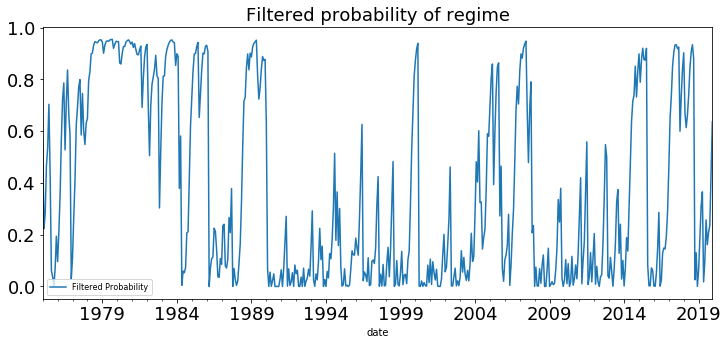

In [21]:
filtered_probability = monthly_return_data.copy()
filtered_probability['Filtered Probability'] = result_em_stochastic_variance.filtered_marginal_probabilities[0]

filtered_probability['Filtered Probability'].plot(figsize=(12,5), fontsize=12)
plt.title('Filtered probability of regime', fontsize=18)
plt.legend(fontsize=8)
plt.tick_params(labelsize=18)

#### 3.2.2 正規性の検定

### 3.3 レジーム間で誤差項の分散が変わる場合 （レジームの数は3個）

In [23]:
model_em_stochastic_variance = sm.tsa.MarkovRegression(monthly_return_data, k_regimes=3, order=1, switching_variance=True)
result_em_stochastic_variance = model_em_stochastic_variance.fit()
result_em_stochastic_variance.summary()

/Users/mkato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  value   No. Observations:                  540
Model:               MarkovRegression   Log Likelihood                 856.620
Date:                Fri, 06 Dec 2019   AIC                          -1689.241
Time:                        01:31:17   BIC                          -1637.742
Sample:                    01-31-1975   HQIC                         -1669.100
                         - 12-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.003      4.772      0.000       0.007       0.017
sigma2         0.0006      0.000      4.934      0.000       0.000       0.001
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0098      0.006     -1.679      0.093      -0.021       0.002
sigma2         0.0047      0.001      7.830      0.000       0.004       0.006
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0145      0.006      2.486      0.013       0.003       0.026
sigma2         0.0026      0.000      5.601      0.000       0.002       0.003
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9297      0.034     27.372      0.000       0.863       0.996
p[1->0]      1.39e-13      0.043   3.26e-12      1.000      -0.083       0.083
p[2->0]        0.0597      0.040      1.493      0.136      -0.019       0.138
p[0->1]        0.0304      0.022      1.390      0.164      -0.012       0.073
p[1->1]        0.9741      0.015     65.562      0.000       0.945       1.003
p[2->1]     3.278e-08        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

## 4. MCMC法による推定

ライブラリPyStanとStanで記述したベイズ・モデルを用いて，上で紹介した単純なレジーム・スイッチング・モデルを推定する．

In [24]:
import pystan

推定結果を表示するための関数を定義しておく．

In [25]:
def sampling_summary_to_df(fit4model):
    """
    :param StanFit4model fit4model:
    :return:
    """
    s = fit4model.summary()
    return pd.DataFrame(s["summary"], columns=s['summary_colnames'], index=s['summary_rownames'])

レジームは2個とし，その他推定に用いるデータをPyStanで扱うための形に整理しておく．

In [26]:
k_regimes = 2
return_data = monthly_return_data['value'].values
T = len(return_data)
dat = {'Y': return_data, 'T': T, 'k_regimes': k_regimes}

### 4.1 事前分布を一様分布にする場合

最初に全てのパラメータの事前分布を無事前情報の一様分布にして推定する．　まず，MCMCのモデルを定義した.stanファイルを読み込む．

In [28]:
with open('markov-switching_model.stan') as f:
    stm = pystan.StanModel(model_code=f.read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19f824c9421a509f0d566c1ca575a550 NOW.


パラメータをMCMC法で推定する．

In [ ]:
n_itr = 5000
n_warmup = 1000
chains = 2

fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)

結果を表示する．結果としては，そこそこうまく推定できているが，レジームの定常確率を表すps[1]の値が0もしくは1と離れている．これは金融的には望ましくない結果である．したがって，次にパラメータの事前分布を変えた推定を行う．

In [ ]:
sampling_summary_to_df(fit).sort_values("Rhat", ascending=False)

### 事前分布を適当に設定する場合
次に，バイアス項の事前分布に標準正規分布を，誤差高の分散の事前分布に逆ガンマ分布を用いた推定結果を表示する．

In [43]:
with open('markov-switching_model-prior.stan') as f:
    stm = pystan.StanModel(model_code=f.read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af89ddee4d83f0b6f902684747e3a5bc NOW.


In [44]:
fit = stm.sampling(data=dat, iter=10000, chains=4, verbose=True)

以下に結果を表示する．心なしかレジームの確率が極端な値を取っており，解釈する側としては望ましい結果が得られた．

In [45]:
sampling_summary_to_df(fit).sort_values("Rhat", ascending=False)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
consts[2],-9.548990,25.704830,36.353937,-72.377684,-35.786851,9.462600,12.886627,15.256373,2.000200,630613.360773
sigma[2],1.920342,2.117584,2.994865,0.112878,0.125258,0.231448,4.053174,7.105642,2.000200,162357.534725
ps[2],0.265265,0.113052,0.159888,0.106601,0.139172,0.212939,0.401827,0.528559,2.000200,10168.444402
lp__,194889.361346,1901.360787,2689.064822,191866.218202,192341.412501,194487.628812,197509.759060,198709.926475,2.000200,2876.487211
ps[1],0.978024,0.004114,0.005818,0.971815,0.973704,0.976352,0.982687,0.987571,2.000201,2517.845821
sigma[1],0.002880,0.000076,0.000107,0.002773,0.002805,0.002843,0.002962,0.003059,2.000219,577.133917
consts[1],0.005204,0.001768,0.002502,0.002357,0.002737,0.004924,0.007630,0.008716,2.003402,32.497635


In [60]:
 temp_array = np.array([[0, 0]]).T

In [129]:
def filter_prob(data, p0, p1, const0, const1, sigma20, sigma21):
    stationary_probs = np.array([[p0, 1-p0], [1-p1, p1]])
    past_probs = np.array([[p0, 1-p0]]).T
    
    prob_list = []
            
    temp_array = np.array([[0., 0.]]).T
    
    for t in range(len(data)):
        temp_array[0] = (np.exp(-(data[t]-const0)**2/(2*sigma20))/np.sqrt(2*np.pi*sigma20))*past_probs[0]
        temp_array[1] = (np.exp(-(data[t]-const1)**2/(2*sigma21))/np.sqrt(2*np.pi*sigma21))*past_probs[0]
        
        denom = np.sum(temp_array)
                
        temp_array /= denom

        past_probs = stationary_probs.dot(temp_array)
        
        prob_list.append(past_probs[0][0])
        
    return prob_list

In [130]:
filter_prob(return_data, 0.978024, 0.265265, 0.005204, -9.548990, 0.002880, 1.920342)

[0.9780239999982557,
 0.9780239999968058,
 0.9780239999980115,
 0.9780239999981809,
 0.978023999997849,
 0.978023999998275,
 0.9780239999965705,
 0.9780239999944716,
 0.9780239999966536,
 0.9780239999902767,
 0.9780239999981085,
 0.9780239999982134,
 0.978023999997233,
 0.9780239999980934,
 0.978023999998077,
 0.9780239999982858,
 0.9780239999981878,
 0.9780239999981519,
 0.9780239999966208,
 0.9780239999982975,
 0.9780239999982978,
 0.9780239999969702,
 0.978023999997392,
 0.9780239999935038,
 0.9780239999980992,
 0.9780239999982931,
 0.9780239999980511,
 0.9780239999982829,
 0.9780239999979238,
 0.9780239999980199,
 0.9780239999978905,
 0.9780239999973308,
 0.978023999998225,
 0.9780239999971433,
 0.9780239999974768,
 0.9780239999979206,
 0.9780239999979888,
 0.9780239999982966,
 0.9780239999981263,
 0.9780239999982938,
 0.9780239999979852,
 0.9780239999982867,
 0.9780239999982735,
 0.9780239999981432,
 0.9780239999982397,
 0.978023999998295,
 0.9780239999982758,
 0.9780239999982409,

In [98]:
result_em_stochastic_variance.params['p[0->0]'] = 0.978024
result_em_stochastic_variance.params['p[0->1]'] = 0.265265
result_em_stochastic_variance.params['const[0]'] = 0.005204
result_em_stochastic_variance.params['const[1]'] = -9.548990
result_em_stochastic_variance.params['sigma2[0]'] = 0.002880
result_em_stochastic_variance.params['sigma2[1]'] = 1.920342

In [58]:
result_em_stochastic_variance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  value   No. Observations:                  540
Model:               MarkovRegression   Log Likelihood                 848.280
Date:                Fri, 06 Dec 2019   AIC                          -1684.560
Time:                        00:20:57   BIC                          -1658.810
Sample:                    01-31-1975   HQIC                         -1674.489
                         - 12-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      5.575      0.000       0.001       0.010
sigma2         0.0029      0.000      6.415      0.000       0.003       0.003
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5490      0.004      0.088      0.930      -9.556      -9.542
sigma2         1.9203      0.000     11.238      0.000       1.920       1.921
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9780      0.022     42.274      0.000       0.934       1.022
p[1->0]        0.0361      0.015      2.411      0.016       0.007       0.065
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

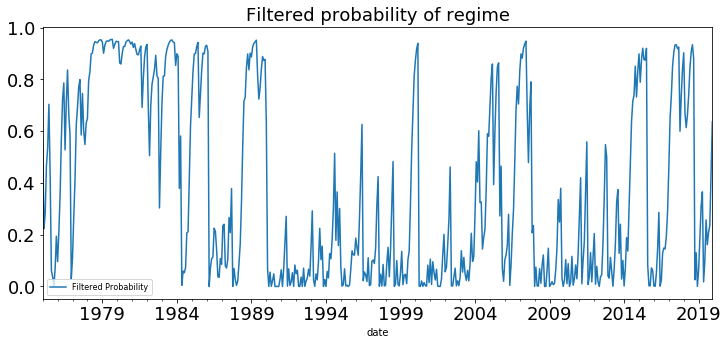

In [59]:
monthly_return_data['Filtered Probability'] = result_em_stochastic_variance.filtered_marginal_probabilities[0]

monthly_return_data['Filtered Probability'].plot(figsize=(12,5), fontsize=12)
plt.title('Filtered probability of regime', fontsize=18)
plt.legend(fontsize=8)
plt.tick_params(labelsize=18)

## 5. ARモデルとの組み合わせ

In [127]:
model_em_stochastic_variance = sm.tsa.MarkovAutoregression(monthly_return_data, k_regimes=2, order=1, switching_variance=True)
result_em_stochastic_variance = model_em_stochastic_variance.fit()
result_em_stochastic_variance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    value   No. Observations:                  539
Model:             MarkovAutoregression   Log Likelihood                 847.129
Date:                  Wed, 04 Dec 2019   AIC                          -1678.259
Time:                          17:04:09   BIC                          -1643.941
Sample:                      01-31-1975   HQIC                         -1664.836
                           - 12-31-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.002      6.003      0.000       0.008       0.016
sigma2         0.0008      0.000      6.508      0.000       0.001       0.001
ar.L1         -0.0877      0.083     -1.057      0.291      -0.250       0.075
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.053      0.958      -0.007       0.008
sigma2         0.0042      0.000     11.209      0.000       0.003       0.005
ar.L1          0.0405      0.057      0.715      0.474      -0.071       0.152
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9416      0.023     41.282      0.000       0.897       0.986
p[1->0]        0.0368      0.015      2.417      0.016       0.007       0.067
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [126]:
model_em_stochastic_variance = sm.tsa.MarkovAutoregression(monthly_return_data, k_regimes=2, order=2, switching_variance=True)
result_em_stochastic_variance = model_em_stochastic_variance.fit()
result_em_stochastic_variance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    value   No. Observations:                  538
Model:             MarkovAutoregression   Log Likelihood                 846.132
Date:                  Wed, 04 Dec 2019   AIC                          -1672.264
Time:                          17:04:02   BIC                          -1629.385
Sample:                      01-31-1975   HQIC                         -1655.492
                           - 12-31-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.002      5.906      0.000       0.008       0.016
sigma2         0.0008      0.000      6.352      0.000       0.001       0.001
ar.L1         -0.0828      0.083     -0.994      0.320      -0.246       0.080
ar.L2         -0.0255      0.084     -0.302      0.763      -0.191       0.140
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.004      0.081      0.935      -0.007       0.008
sigma2         0.0042      0.000     11.087      0.000       0.003       0.005
ar.L1          0.0400      0.058      0.690      0.490      -0.074       0.153
ar.L2         -0.0070      0.059     -0.118      0.906      -0.123       0.109
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9403      0.023     40.205      0.000       0.894       0.986
p[1->0]        0.0391      0.016      2.417      0.016       0.007       0.071
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [125]:
model_em_stochastic_variance = sm.tsa.MarkovAutoregression(monthly_return_data, k_regimes=2, order=3, switching_variance=True)
result_em_stochastic_variance = model_em_stochastic_variance.fit()
result_em_stochastic_variance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    value   No. Observations:                  537
Model:             MarkovAutoregression   Log Likelihood                 841.211
Date:                  Wed, 04 Dec 2019   AIC                          -1658.423
Time:                          17:03:43   BIC                          -1606.991
Sample:                      01-31-1975   HQIC                         -1638.303
                           - 12-31-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0193      0.003      5.556      0.000       0.012       0.026
sigma2         0.0012      0.000      5.776      0.000       0.001       0.002
ar.L1         -0.0797      0.066     -1.209      0.227      -0.209       0.049
ar.L2         -0.2160      0.065     -3.314      0.001      -0.344      -0.088
ar.L3         -0.2740      0.073     -3.740      0.000      -0.418      -0.130
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0082      0.005     -1.516      0.130      -0.019       0.002
sigma2         0.0030      0.000      6.458      0.000       0.002       0.004
ar.L1          0.3927      0.091      4.296      0.000       0.214       0.572
ar.L2          0.2060      0.088      2.333      0.020       0.033       0.379
ar.L3          0.4013      0.072      5.583      0.000       0.260       0.542
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.3390      0.131      2.582      0.010       0.082       0.596
p[1->0]        0.7489      0.090      8.347      0.000       0.573       0.925
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""